In [300]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [301]:
df_train = pd.read_csv("train.csv")
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


1) Limpe a base de dados. Nesta etapa você deve decidir o que fazer com as instâncias que possuem
dados faltantes: preencher os dados faltantes de acordo com alguma regra? Descartar as instâncias que
possuem dados faltantes?

Primeiramente, descobri quais colunas possuem dados faltantes.

In [302]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Como observado acima, as colunas Age, Cabin e Embarked são as únicas. Não podemos deletar nenhuma linha do data frame, pois todas (pessoas) são fundamentais para o estudo, então vamo analisar o que pode ser feito com cada coluna:

Age: 177 pessoas sem idade identificada, vou optar por preenchê-los com a idade média.

In [303]:
# Primeiro, devo descobrir a idade média
average = math.floor(df_train['Age'].mean())

# Agora vou substituir os NaN da coluna Age, pela média descoberta
df_train.update(df_train['Age'].fillna(average))
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Passando para Cabin: 687 pessoas tiveram os dados de sua cabine perdidos, como não é possível advinhar em qual cabine cada pessoa estava, vou apenas atualizar os valores NaN para 'NI'* no data frame. Observação: não utilizarei essa coluna posteriormente para treinar a máquina, apenas mudei o valor para fins visuais, poderia ter excluido a coluna, mas caso alguém queira verificar a cabine de uma pessoa específica, será possível.

*NI refere-se a Not Identified.

In [304]:
df_train.update(df_train['Cabin'].fillna('NI'))
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       2
dtype: int64

Chegando na última coluna, encontramos apenas duas pessoas com seus dados de cidade de embarque perdidos. Para tal, decidi verificar a quantidade de embarque em cada cidade, assim consigo visualizar a qual cidade a pessoa pode ser atribuida.

In [305]:
df_train.groupby("Embarked").count()['PassengerId']

Embarked
C    168
Q     77
S    644
Name: PassengerId, dtype: int64

Utilizando o PassengerId - o qual presumi que seja único - percebi a discrepante diferença na quantidade de pessoas que saem de southampton, S. Portanto atribuí S para ambas pessoas com cidade de embarque faltante.

In [306]:
df_train.update(df_train['Embarked'].fillna('S'))
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

2) Faça a conversão dos atributos categóricos em atributos numéricos. Estas conversões devem ser
realizadas considerando se o atributo categórico é ordinal ou não.

In [307]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


De acordo com a especificação do projeto, os atributos categóricos são Sex e Embarked. Começando em Sex, substituirei masculino para 0 e feminino para 1. E então o Embarked será substituido de C para 0, Q para 1 e S para 2.

In [308]:
df_train['Sex'].replace("male", 0, inplace=True)
df_train['Sex'].replace("female", 1, inplace=True)
df_train['Embarked'].replace("C", 0, inplace=True)
df_train['Embarked'].replace("Q", 1, inplace=True)
df_train['Embarked'].replace("S", 2, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 83.7+ KB


Como observado acima, os atributos se tornaram do tipo int.

3) Explore a base de dados. Conheça a distribuição dos atributos de entrada em relação aos atributos
de entrada. A partir da exploração é possível ter uma idéia de quais atributos podem conter mais
informação útil para realizar a classificação.

Abaixo, vou fazer vários gráficos para verificar quais dados são melhores para verificar as probabilidades de sobrevivência de acordo com algum atributo. Utilizarei gráficos baseados em proporção, não em quantidade, assim tenho melhores dados para análise. Um adendo: não utilizarei o atributo idade por ter muitos campos vazios no DF (os quais preenchi com a média das idades), porque poderia utilizar muitos dados falsos, prejudicando, por exemplo, a análise de crianças sobreviventes.

Primeiramente, verificando o histograma de sobreviventes por sexo, observa-se que há uma proporção de sobrevivência muito maior de mulheres.

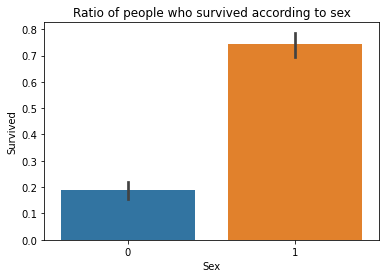

In [309]:
survivors_class = df_train.copy()
survivors_class['Survived'] = df_train['Survived'] == 1

sns.barplot(data=survivors_class, y='Survived', x='Sex')
plt.title('Ratio of people who survived according to sex')
plt.show()

####    0 = homem      1 = mulher    ####

Passando agora para as classes, pode se observar que a proporção de sobrevivência de pessoas mais ricas, foi consideravelmente maior.

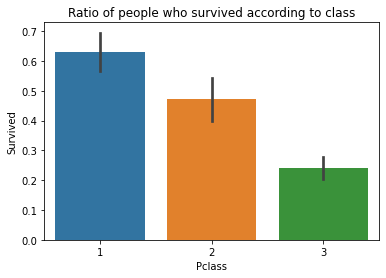

In [310]:
survivors_class = df_train.copy()
survivors_class['Survived'] = df_train['Survived'] == 1

sns.barplot(data=survivors_class, y='Survived', x='Pclass')
plt.title('Ratio of people who survived according to class')
plt.show()

####    0 = primeira classe      1 = segunda classe      2 = terceira classe    ####

Um outro atributo que encontrei com diferenças consideráveis foi a cidade de embarque.

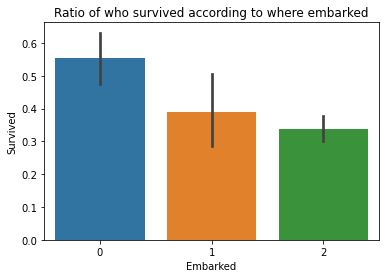

In [311]:
survivors_embarked = df_train.copy()
survivors_embarked['Embarked'] = df_train['Survived'] == 1
sns.barplot(data=survivors_class, y='Survived', x='Embarked')
plt.title('Ratio of who survived according to where embarked')
plt.show()

####    0 = C (Cherbourg)      1 = Q (Queenstown)      2 = S (Southampton)   ####

4) Normalize os dados de acordo com o que estudamos na aula.

Primeiro atribuí os atributos escolhidos ao df, assim já consegui obter apenas os cados que eu queria normalizados.

In [329]:
df = df_train.copy()


atributes = ['Pclass', 'Sex', 'Embarked']
X = df[atributes]
y = df['Survived']

X = StandardScaler().fit_transform(X)


5) Visualize o espaço de características usando a técnica PCA. Isto dará uma idéia da separabilidade das
classes a partir dos atributos que você escolheu.

Ao fazer o PCA, pode-se observar que os atributos foram bem escolhidos, já que ficaram claramente separados

<AxesSubplot:xlabel='PC 0', ylabel='PC 1'>

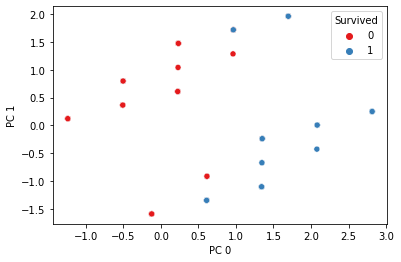

In [331]:
pca = PCA(n_components=2)
pca.fit(X)

X_pca = pca.transform(X)  # Projetar os 3 atributos nos 2 componentes principais
X_pca_df = pd.DataFrame(X_pca, columns=['PC 0', 'PC 1']) # Aqui, nota-se que a dimensionalidade dos dados projetados agora tem apenas 2 atributos!

# Plota os dados projetados nos componentes principais. Colorir os pontos de acordo com o Survived
sns.set_palette('seismic')
sns.scatterplot(data=X_pca_df, x='PC 0', y='PC 1', hue=y, palette='Set1')

# #calcular a média do valor dos atributos para cada classe.
# df.groupby('Survived').mean().transpose()

6) Utilize ambos classificadores estudados até o momento: KNN e SVM. Os hiperparâmetros devem ser
selecionados usando o processo de validação cruzada, descrito a seguir.

7) Realize o processo de validação cruzada duplo. No primeiro nível você deve usar validação cruzada em
k-vias para avaliar o desempenho do seu classificador em particionamentos diferentes. Use a métrica
de classificação que julgar adequada para este problema. No segundo nível você deve usar a validação
cruzada para escolher a melhor combinação de hiperparâmetros para o classificador.
8) Selecione o melhor modelo gerado usando análise estatística do desempenho obtido pelos classificadores
durante a validação cruzada. Faça esta seleção de forma automática!
9) Apresente os resultados da classificação com todos os modelos, apresentando as métricas de classificação
por classe e também da classificação como um todo.
10) Repita os passos acima para desenvolver classificadores cada vez mais sofisticados :)